In [ ]:
%matplotlib inline

import numpy as np
from keras.layers import Input, Dense, Activation, BatchNormalization, PReLU, Dropout
from keras.models import Model
from keras.optimizers import SGD
from keras.utils import to_categorical
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [4]:
Xs=np.load('../ft-feature/trainall_feature.npy')
ys=np.load('../ft-feature/trainall_label.npy')
print(Xs.shape)
print(ys.shape)
Xt=np.load('../ft-feature/test_feature.npy')
yt=np.load('../ft-feature/test_label.npy')

(17670, 512)
(17670, 1)


In [5]:
def build_models(n_neurons):
    """Creates three different models, one used for source only training, two used for domain adaptation"""
    inputs = Input(shape=(512,)) 
    x4 = Dense(n_neurons, activation='linear')(inputs)
    x4 = BatchNormalization()(x4)
    x4 = Activation("elu")(x4)  

    source_classifier = Dense(2, activation='softmax', name="mo")(x4)  
    domain_classifier = Dense(32, activation='linear', name="do4")(x4)
    domain_classifier = BatchNormalization(name="do5")(domain_classifier)
    domain_classifier = Activation("elu", name="do6")(domain_classifier)
    domain_classifier = Dropout(0.5)(domain_classifier)

    domain_classifier = Dense(2, activation='softmax', name="do")(domain_classifier)

    comb_model = Model(inputs=inputs, outputs=[source_classifier, domain_classifier])
    comb_model.compile(optimizer="Adam",
              loss={'mo': 'categorical_crossentropy', 'do': 'categorical_crossentropy'},
              loss_weights={'mo': 1, 'do': 2}, metrics=['accuracy'], )

    source_classification_model = Model(inputs=inputs, outputs=[source_classifier])
    source_classification_model.compile(optimizer="Adam",
              loss={'mo': 'categorical_crossentropy'}, metrics=['accuracy'], )


    domain_classification_model = Model(inputs=inputs, outputs=[domain_classifier])
    domain_classification_model.compile(optimizer="Adam",
                  loss={'do': 'categorical_crossentropy'}, metrics=['accuracy'])
    
    
    embeddings_model = Model(inputs=inputs, outputs=[x4])
    embeddings_model.compile(optimizer="Adam",loss = 'categorical_crossentropy', metrics=['accuracy'])
                        
                        
    return comb_model, source_classification_model, domain_classification_model, embeddings_model

def batch_generator(data, batch_size):
    """Generate batches of data.

    Given a list of numpy data, it iterates over the list and returns batches of the same size
    This
    """
    all_examples_indices = len(data[0])
    while True:
        mini_batch_indices = np.random.choice(all_examples_indices, size=batch_size, replace=False)
        tbr = [k[mini_batch_indices] for k in data]
        yield tbr

Train function takes source and target information and train the network. Note that target labels are not used for training

In [6]:
#SAMPLING_ITERATIONS = 3000

def train(Xs, ys, Xt, yt,  enable_dann = True, n_iterations = 15000):
    
    batch_size = 64
    
    model, source_classification_model, domain_classification_model, embeddings_model = build_models(512)

    y_class_dummy = np.ones((len(Xt), 2))
    y_adversarial_1 = to_categorical(np.array(([1] * batch_size + [0] * batch_size)))
    
    sample_weights_class = np.array(([1] * batch_size + [0] * batch_size))
    sample_weights_adversarial = np.ones((batch_size * 2,))

    S_batches = batch_generator([Xs, to_categorical(ys)], batch_size)
    T_batches = batch_generator([Xt, np.zeros(shape = (len(Xt),2))], batch_size)
    
    for i in range(n_iterations):
        # # print(y_class_dummy.shape, ys.shape)
        y_adversarial_2 = to_categorical(np.array(([0] * batch_size + [1] * batch_size)))

        X0, y0 = next(S_batches)
        X1, y1 = next(T_batches)


        X_adv = np.concatenate([X0, X1])
        y_class = np.concatenate([y0, np.zeros_like(y0)])

        adv_weights = []
        for layer in model.layers:
            if (layer.name.startswith("do")):
                adv_weights.append(layer.get_weights())

        if(enable_dann):
            # note - even though we save and append weights, the batchnorms moving means and variances
            # are not saved throught this mechanism 
            stats = model.train_on_batch(X_adv, [y_class, y_adversarial_1],
                                     sample_weight=[sample_weights_class, sample_weights_adversarial])
            
            k = 0
            for layer in model.layers:
                if (layer.name.startswith("do")):
                    layer.set_weights(adv_weights[k])
                    k += 1

            class_weights = []
            
        
            for layer in model.layers:
                if (not layer.name.startswith("do")):
                    class_weights.append(layer.get_weights())
            
            stats2 = domain_classification_model.train_on_batch(X_adv, [y_adversarial_2])

            k = 0
            for layer in model.layers:
                if (not layer.name.startswith("do")):
                    layer.set_weights(class_weights[k])
                    k += 1

        else:
            source_classification_model.train_on_batch(X0,y0)
            
       
        if ((i + 1) % 1000 == 0):
            # print(i, stats)
            y_test_hat_t = source_classification_model.predict(Xt).argmax(1)
            y_test_hat_s = source_classification_model.predict(Xs).argmax(1)
            print("Iteration %d, source accuracy =  %.3f, target accuracy = %.3f"%(i, accuracy_score(ys, y_test_hat_s), accuracy_score(yt, y_test_hat_t)))
    return embeddings_model

In [7]:
embs = train(Xs, ys, Xt, yt, enable_dann = False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Iteration 999, source accuracy =  0.987, target accuracy = 0.748
Iteration 1999, source accuracy =  0.986, target accuracy = 0.761
Iteration 2999, source accuracy =  0.985, target accuracy = 0.740
Iteration 3999, source accuracy =  0.990, target accuracy = 0.753
Iteration 4999, source accuracy =  0.991, target accuracy = 0.780
Iteration 5999, source accuracy =  0.993, target accuracy = 0.770
Iteration 6999, source accuracy =  0.995, target accuracy = 0.743
Iteration 7999, source accuracy =  0.996, target accuracy = 0.756
Iteration 8999, source accuracy =  0.996, target accuracy = 0.739
Iteration 9999, source accuracy =  0.997, target accuracy = 0.768
Iteration 10999, source accuracy =  0.997, target accuracy = 0.762
Iteration 11999, source accuracy =  0.998, target accuracy = 0.763
Iteration 12999, source accuracy =  0.997, target accuracy = 0.771
Iteration 13999, sou

We can now plot the embedding layer activations - note that the process is not deterministic  -notice how it's impossible to learn a linear classifier that is sucessfull in both datasets using the features learned.

In [8]:
Xs_act = embs.predict(Xs)
Xt_act = embs.predict(Xt)

plt.scatter(Xs_act[:,0], Xs_act[:,1], c=[["lightgreen", "tomato"][k] for k in ys], alpha=0.4)
plt.scatter(Xt_act[:,0], Xt_act[:,1], c=[["g", "red"][k] for k in yt],  alpha=0.4)

TypeError: only integer scalar arrays can be converted to a scalar index

In [9]:
embs = train(Xs, ys, Xt, yt, enable_dann = True)

Iteration 999, source accuracy =  0.956, target accuracy = 0.728
Iteration 1999, source accuracy =  0.941, target accuracy = 0.727
Iteration 2999, source accuracy =  0.911, target accuracy = 0.713
Iteration 3999, source accuracy =  0.969, target accuracy = 0.741
Iteration 4999, source accuracy =  0.982, target accuracy = 0.762
Iteration 5999, source accuracy =  0.981, target accuracy = 0.759
Iteration 6999, source accuracy =  0.986, target accuracy = 0.765
Iteration 7999, source accuracy =  0.987, target accuracy = 0.751
Iteration 8999, source accuracy =  0.972, target accuracy = 0.751
Iteration 9999, source accuracy =  0.989, target accuracy = 0.771
Iteration 10999, source accuracy =  0.984, target accuracy = 0.767
Iteration 11999, source accuracy =  0.988, target accuracy = 0.762
Iteration 12999, source accuracy =  0.987, target accuracy = 0.768
Iteration 13999, source accuracy =  0.989, target accuracy = 0.777
Iteration 14999, source accuracy =  0.991, target accuracy = 0.770


Again, we can plot the activations - note that the activations learned between runs can be quite different, but notice the collapse of all green and red dots into similiar regions

In [12]:
Xs_act_DANN = embs.predict(Xs)
Xt_act_DANN = embs.predict(Xt)
print(Xs_act_DANN.shape)
print(Xt_act_DANN.shape)

(17670, 512)
(967, 512)


In [ ]:
np.save('train_feature')

In [14]:
act_DANN=np.concatenate([Xs_act_DANN,Xt_act_DANN])
from MulticoreTSNE import MulticoreTSNE as TSNE
embeddings_all= TSNE(n_jobs=4).fit_transform(act_DANN)

In [15]:
print(embeddings_all.shape)

(18637, 2)


In [17]:
print(embeddings_all.shape)
vis_x = embeddings_all[:, 0]
vis_y = embeddings_all[:, 1]
print(vis_x)
print(vis_y)
target1=np.load('../ft-feature/trainall_label.npy')[:,0]
target2=np.load('../ft-feature/test_label.npy')[:,0]
target2=target2+2
target_all=np.concatenate([target1,target2],axis=0)
print(target_all.shape)

(18637, 2)
[-30.42191778 -23.92331051 -34.97257095 ...  40.83333863 -16.31045889
  15.48896317]
[-18.04061946 -28.02949886   2.99102001 ... -13.38611358 -14.60987711
  -8.97682967]
(18637,)


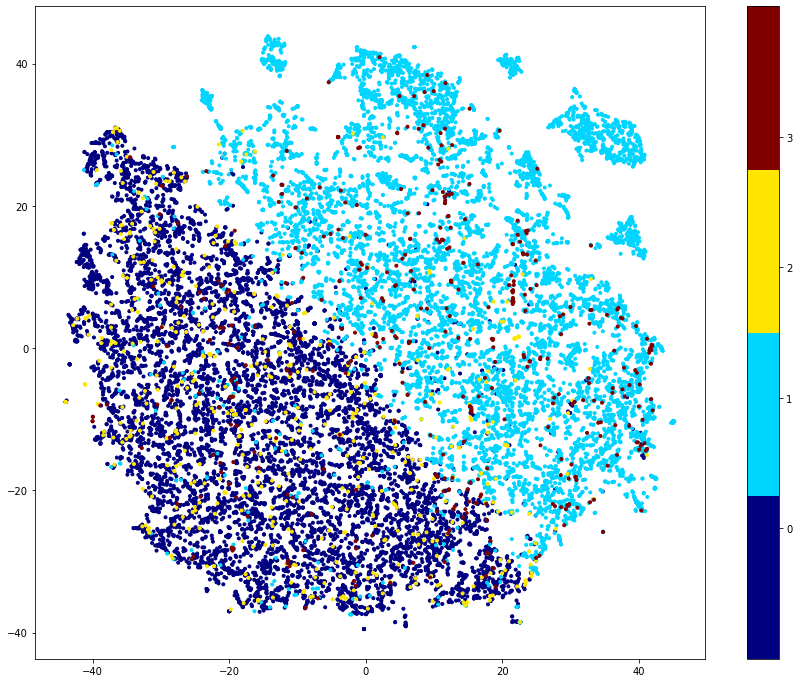

In [18]:
plt.figure(figsize=(15,12))
plt.scatter(vis_x, vis_y, c=target_all, cmap=plt.cm.get_cmap("jet", 4), marker='.')
plt.colorbar(ticks=range(4))
plt.clim(-1, 4)
plt.show()